# Simulation Model Training

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of AI for Health (AIH), Talavera-López Lab
- **Date of Creation:** 26.06.2024
- **Date of Last Modification:** 02.07.2024

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gdown
import os
import random
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_ms_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                generate_enriched_gp_info_plots)

/home/aih/sebastian.birk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/urllib3/connectionpool.py", line 715, in urlopen
    httplib_response = self._make_request(
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/urllib3/connectionpool.py", line 404, in _make_request
    self._validate_conn(conn)
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/urllib3/connectionpool.py", line 1058, in _validate_conn
    conn.connect()
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/urlli

### 1.2 Define Parameters

In [14]:
### Dataset ###
dataset_name = "sim_ref_951genes_100locs_strongincrements"
species = "mouse"
spatial_key = "spatial"
n_neighbors = 8

### Model ###
# AnnData Keys
counts_key = "counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
conv_layer_encoder = "gcnconv" # change to "gatv2conv" if enough compute and memory
active_gp_thresh_ratio = 0.01

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 0. # increase if gene selection desired
lambda_l1_addon = 100.
edge_batch_size = 1024 # increase if more memory available
n_sampled_neighbors = 8
use_cuda_if_available = True

### Analysis ###
cell_type_key = "cell_types"
niche_type_key = "niche_types"
latent_leiden_resolution = 0.4
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "batch"
spot_size = 40
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

### 1.3 Run Notebook Setup

In [4]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths

In [6]:
# Define paths
ga_data_folder_path = "../../datasets/ga_data"
gp_data_folder_path = "../../datasets/gp_data"
st_data_folder_path = "../../datasets/st_data"
st_data_gold_folder_path = st_data_folder_path + "/gold"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
collectri_tf_network_file_path = f"{gp_data_folder_path}/collectri_tf_network_{species}.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"../../artifacts"
model_folder_path = f"{artifacts_folder_path}/data_simulation/{current_timestamp}/model"
figure_folder_path = f"{artifacts_folder_path}/data_simulation/{current_timestamp}/figures"

### 1.5 Create Directories

In [7]:
os.makedirs(model_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(st_data_folder_path, exist_ok=True)

## 2. Prepare Model Training

### 2.1 Create Prior Knowledge Gene Program (GP) Mask

- NicheCompass expects a prior GP mask as input, which it will use to make its latent feature space interpretable (through linear masked decoders). 
- The user can provide a custom GP mask to NicheCompass based on the biological question of interest.
- As a default, here we create a GP mask based on three databases of prior knowledge of inter- and intracellular interaction pathways:
    - OmniPath (Ligand-Receptor GPs)
    - MEBOCOST (Enzyme-Sensor GPs)
    - NicheNet (Combined Interaction GPs)

In [9]:
# Retrieve OmniPath GPs (source: ligand genes; target: receptor genes)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    load_from_disk=True,
    save_to_disk=False,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=False)

In [10]:
# Retrieve NicheNet GPs (source: ligand genes; target: receptor genes, target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    load_from_disk=True,
    save_to_disk=False,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=False)

In [11]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_ms_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=False)

In [12]:
# Filter and combine GPs
gp_dicts = [omnipath_gp_dict, nichenet_gp_dict, mebocost_gp_dict]
combined_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dicts,
    verbose=True)

print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_gp_dict)}.")

Combining ACE2_ligand_receptor_GP and Ace2_ligand_receptor_target_gene_GP.
Combining ACE2_ligand_receptor_GP and L-Phenylalanine_metabolite_enzyme_sensor_GP.
Combining ADCYAP1_ligand_receptor_GP and Adcyap1_ligand_receptor_target_gene_GP.
Combining ADGRE5_ligand_receptor_GP and Adgre5_ligand_receptor_target_gene_GP.
Combining ADIPOQ_ligand_receptor_GP and Adipoq_ligand_receptor_target_gene_GP.
Combining ADM_ligand_receptor_GP and Adm_ligand_receptor_target_gene_GP.
Combining ADM2_ligand_receptor_GP and Adm2_ligand_receptor_target_gene_GP.
Combining AGRP_ligand_receptor_GP and Agrp_ligand_receptor_target_gene_GP.
Combining AGT_ligand_receptor_GP and Agt_ligand_receptor_target_gene_GP.
Combining ALCAM_ligand_receptor_GP and Alcam_ligand_receptor_target_gene_GP.
Combining ALKAL1_ligand_receptor_GP and Alkal1_ligand_receptor_target_gene_GP.
Combining ALKAL2_ligand_receptor_GP and Alkal2_ligand_receptor_target_gene_GP.
Combining AMBN_ligand_receptor_GP and Ambn_ligand_receptor_target_gene_G

In [14]:
# Filter and combine GPs
gp_dicts = [omnipath_gp_dict, nichenet_gp_dict]

combined_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dicts,
    verbose=True)
combined_gp_dict.update(mebocost_gp_dict)

print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_gp_dict)}.")

Combining ACE2_ligand_receptor_GP and Ace2_ligand_receptor_target_gene_GP.
Combining ADAM11_ligand_receptor_GP and Adam11_ligand_receptor_target_gene_GP.
Combining ADAMTS3_ligand_receptor_GP and Adamts3_ligand_receptor_target_gene_GP.
Combining ADCYAP1_ligand_receptor_GP and Adcyap1_ligand_receptor_target_gene_GP.
Combining ADGRE5_ligand_receptor_GP and Adgre5_ligand_receptor_target_gene_GP.
Combining ADIPOQ_ligand_receptor_GP and Adipoq_ligand_receptor_target_gene_GP.
Combining ADM_ligand_receptor_GP and Adm_ligand_receptor_target_gene_GP.
Combining ADM2_ligand_receptor_GP and Adm2_ligand_receptor_target_gene_GP.
Combining AGRP_ligand_receptor_GP and Agrp_ligand_receptor_target_gene_GP.
Combining AGT_ligand_receptor_GP and Agt_ligand_receptor_target_gene_GP.
Combining ALCAM_ligand_receptor_GP and Alcam_ligand_receptor_target_gene_GP.
Combining ALKAL1_ligand_receptor_GP and Alkal1_ligand_receptor_target_gene_GP.
Combining ALKAL2_ligand_receptor_GP and Alkal2_ligand_receptor_target_gene

### 2.2 Load Data & Compute Spatial Neighbor Graph

- NicheCompass expects a precomputed spatial adjacency matrix stored in 'adata.obsp[adj_key]'.
- The user can customize the spatial neighbor graph construction based on the biological question of interest.

In [16]:
dataset_name

'sim_ref_951genes_100locs_strongincrements'

In [17]:
# Read data
adata = sc.read_h5ad(f"{st_data_gold_folder_path}/{dataset_name}/{dataset_name}.h5ad")

In [18]:
# Compute spatial neighborhood
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)

# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

### 2.3 Add GP Mask to Data

In [19]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=2,
    min_source_genes_per_gp=1,
    min_target_genes_per_gp=1,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

### 2.4 Explore Data

In [20]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key=cell_type_key)

Number of nodes (observations): 100
Number of node features (genes): 951


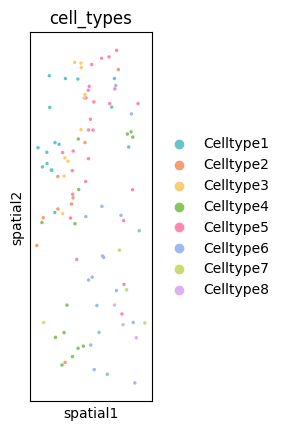

In [21]:
print(f"Number of nodes (observations): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sc.pl.spatial(adata,
              color=cell_type_key,
              palette=cell_type_colors,
              spot_size=spot_size)        

## 3. Train Model

### 3.1 Initialize, Train & Save Model

In [57]:
# Initialize model
model = NicheCompass(adata,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                     latent_key=latent_key,
                     conv_layer_encoder=conv_layer_encoder,
                     active_gp_thresh_ratio=active_gp_thresh_ratio)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 951, n_cat_covariates_embed_input: 0, n_hidden: 315, n_latent: 215, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 215, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 951
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 215, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 951


In [58]:
lambda_edge_recon = 0

In [59]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            n_sampled_neighbors=n_sampled_neighbors,
            use_cuda_if_available=use_cuda_if_available,
            verbose=False)


--- INITIALIZING TRAINER ---
Number of training nodes: 90
Number of validation nodes: 10
Number of training edges: 443
Number of validation edges: 49
Edge batch size: 1024
Node batch size: None

--- MODEL TRAINING ---
Epoch 1/400 |--------------------| 0.2% train_global_loss: 784252.1875; train_optim_loss: 784252.1875; val_global_loss: 746992.0625; val_optim_loss: 746992.0625
Epoch 2/400 |--------------------| 0.5% train_global_loss: 763601.2500; train_optim_loss: 763601.2500; val_global_loss: 736047.1875; val_optim_loss: 736047.1875
Epoch 3/400 |--------------------| 0.8% train_global_loss: 748252.2500; train_optim_loss: 748252.2500; val_global_loss: 725452.8750; val_optim_loss: 725452.8750
Epoch 4/400 |--------------------| 1.0% train_global_loss: 736779.2500; train_optim_loss: 736779.2500; val_global_loss: 716013.2500; val_optim_loss: 716013.2500
Epoch 5/400 |--------------------| 1.2% train_global_loss: 727208.8125; train_optim_loss: 727208.8125; val_global_loss: 714833.1250; val_

In [60]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [61]:
# Save trained model
model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

## 4. Analysis

In [62]:
#load_timestamp = "30062024_162615"
load_timestamp = current_timestamp # uncomment if you trained the model in this notebook

figure_folder_path = f"{artifacts_folder_path}/data_simulation/{load_timestamp}/figures"
model_folder_path = f"{artifacts_folder_path}/data_simulation/{load_timestamp}/model"

os.makedirs(figure_folder_path, exist_ok=True)

In [63]:
# Load trained model
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name="adata.h5ad",
                          gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 951, n_cat_covariates_embed_input: 0, n_hidden: 315, n_latent: 215, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 215, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 951
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 215, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 951


In [64]:
model.adata.obs[sample_key] = "batch1"

In [65]:
samples = model.adata.obs[sample_key].unique().tolist()

### 4.1 Visualize NicheCompass Latent GP Space

Let's look at the preservation of cell type annotations in the latent GP space. Note that the goal of NicheCompass is not a separation of cell types but rather to identify spatially consistent cell niches.

In [66]:
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=cell_type_key)

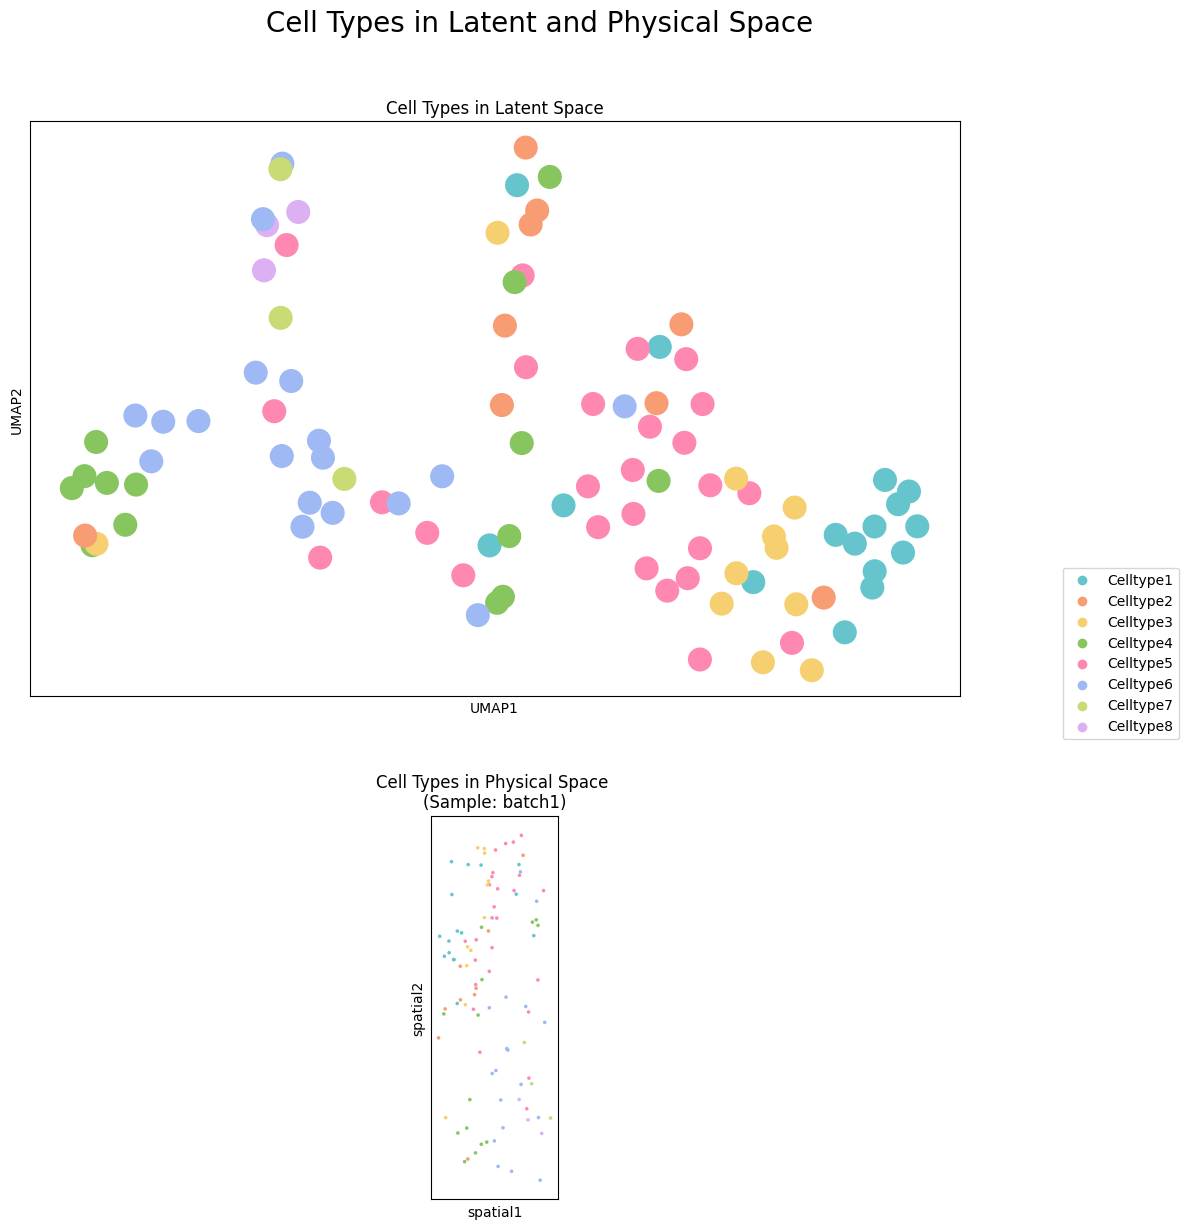

In [67]:
# Create plot of cell type annotations in physical and latent space
groups = None
save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"Cell Types " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           groups=groups,palette=cell_type_colors,
           title=f"Cell Types in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[cell_type_key],
                  groups=groups,
                  palette=cell_type_colors,
                  spot_size=spot_size,
                  title=f"Cell Types in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 4.2 Identify Niches

We compute Leiden clustering of the NicheCompass latent GP space to identify spatially consistent cell niches.

In [68]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [69]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

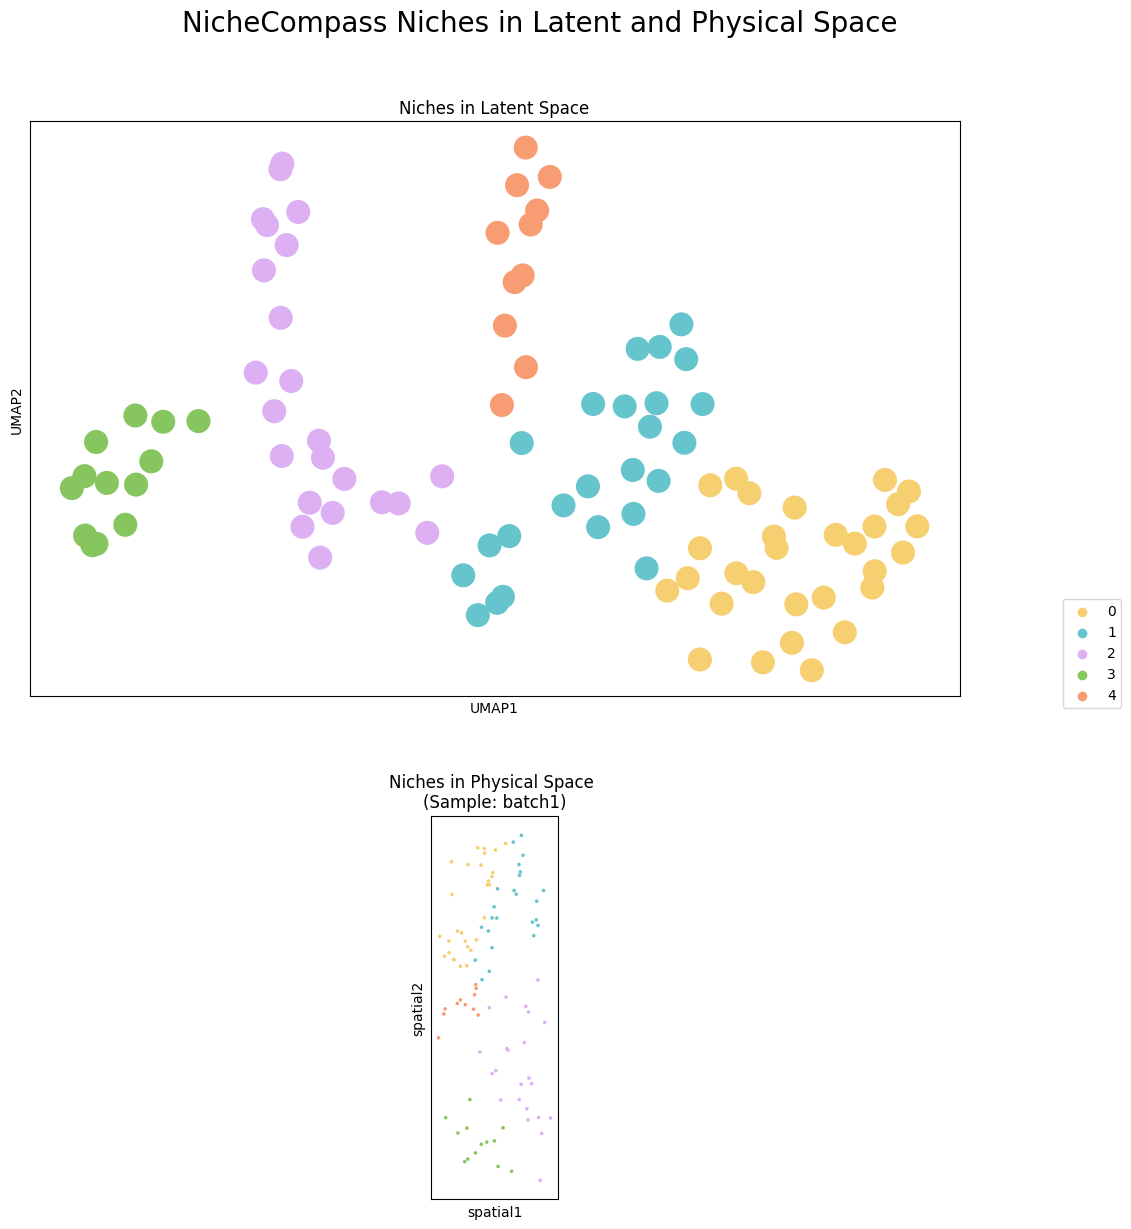

In [70]:
# Create plot of latent cluster / niche annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["17"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "niches_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Niches " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           palette=latent_cluster_colors,
           title=f"Niches in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[latent_cluster_key],
                  groups=groups,
                  palette=latent_cluster_colors,
                  spot_size=spot_size,
                  title=f"Niches in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 4.3 Evaluation

- Clone SDMBench from: https://github.com/zhaofangyuan98/SDMBench/tree/main/SDMBench
- Some slight modifications to the SDMBench source code were necessary to get it to run

In [35]:
adata = sc.read_h5ad(f"{st_data_gold_folder_path}/{dataset_name}/{dataset_name}.h5ad")

In [33]:
import sys
sys.path.append("../../SDMBench/SDMBench")

In [18]:
from SDMBench import sdmbench

In [34]:
ari = sdmbench.compute_ARI(
    model.adata,
    "niche_types",
    latent_cluster_key)

0.9122319538862617

In [35]:
nmi = sdmbench.compute_NMI(
    model.adata,
    "niche_types",
    latent_cluster_key)

In [46]:
chaos = sdmbench.compute_CHAOS(
    model.adata,
    latent_cluster_key)
chaos

0.018238571736137042

In [51]:
pas = sdmbench.compute_PAS(
    model.adata,
    latent_cluster_key,
    spatial_key="spatial")

In [39]:
asw = sdmbench.compute_ASW(
    model.adata,
    latent_cluster_key,
    spatial_key="spatial")

-0.11457277081644343

In [40]:
hom = sdmbench.compute_HOM(
    model.adata,
    "niche_types",
    latent_cluster_key)

0.9060802417434227

In [41]:
com = sdmbench.compute_COM(
    model.adata,
    "niche_types",
    latent_cluster_key)

In [43]:
moranI, gearyC = sdmbench.marker_score(
    model.adata,
    "niche_types")

  0%|          | 0/100 [00:00<?, ?/s]

  0%|          | 0/100 [00:00<?, ?/s]

In [54]:
output_df = pd.DataFrame([[nmi,hom,com,chaos,pas,asw,moranI,gearyC]],
               index = ["NicheCompass"],#your method name
               columns=[['Accuracy','Accuracy','Accuracy','Continuity','Continuity','Continuity','Marker score','Marker score'],
                        ['NMI','HOM','COM','CHAOS','PAS','ASW','Moran\'I','Geary\'s C']])

In [55]:
output_df

Accuracy                    Continuity                    \
                  NMI      HOM       COM      CHAOS     PAS       ASW   
NicheCompass  0.90298  0.90608  0.899901   0.018239  0.0098 -0.114573   

             Marker score            
                  Moran'I Geary's C  
NicheCompass     0.221907  0.777219

### 4.3 Characterize Niches

Now we will characterize the identified cell niches.

#### 4.3.2 Differential GPs

Now we can test which GPs are differentially expressed in a niche. To this end, we will perform differential GP testing of a selected niche, e.g. niche "17" (```selected_cats = ["17"]```) vs all other niches (```comparison_cats = "rest"```). However, differential GP testing can also be performed in the following ways:
- Set ```selected_cats = None``` to perform differential GP testing across all niches, as opposed to just for one specific niche.
- Set ```comparison_cats = ["19"]``` to perform differential GP testing against niche "19" as opposed to against all other niches.

We choose an absolute log bayes factor threshold of 2.3 to determine strongly enriched GPs (see https://en.wikipedia.org/wiki/Bayes_factor).

In [71]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 315.
Number of active gene programs: 315.


In [72]:
# Display example active GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

gp_name  all_gp_idx  gp_active  \
0                      CCL15_ligand_receptor_GP           0       True   
1                      CCL23_ligand_receptor_GP           1       True   
2                      CCL27_ligand_receptor_GP           2       True   
3        COMPLEX:INHBA_INHBB_ligand_receptor_GP           3       True   
4  COMPLEX:LAMA1_LAMB1_LAMC1_ligand_receptor_GP           4       True   

   active_gp_idx  n_source_genes  n_non_zero_source_genes  n_target_genes  \
0              0               1                        1               1   
1              1               1                        1               1   
2              2               3                        3               2   
3              3               2                        2               4   
4              4               1                        1               1   

   n_non_zero_target_genes            gp_source_genes  \
0                        1                     [Ccl9]   
1                        1                     [Ccl9]   
2                        2  [Ccl27b, Ccl27a, Gm13306]   
3                        4             [Inhba, Inhbb]   
4                        1                    [Lama1]   

                    gp_target_genes     gp_source_genes_weights  \
0                            [CCR3]                    [0.0534]   
1                           [Ackr2]                    [0.0146]   
2                    [Ackr2, Ccr10]  [-0.1092, 0.0481, -0.0282]   
3  [Acvr1c, Acvr2b, Acvr1b, Acvr2a]          [-0.0926, -0.0244]   
4                           [Itgb1]                   [-0.0687]   

              gp_target_genes_weights gp_source_genes_importances  \
0                            [0.0499]                    [0.5171]   
1                            [0.0452]                    [0.2441]   
2                  [-0.0633, -0.0042]    [0.4317, 0.1901, 0.1113]   
3  [-0.0845, 0.0221, -0.016, -0.0019]             [0.3834, 0.101]   
4                            [0.0239]                    [0.7418]   

        gp_target_genes_importances  
0                          [0.4829]  
1                          [0.7559]  
2                  [0.2502, 0.0167]  
3  [0.3499, 0.0914, 0.0664, 0.0079]  
4                          [0.2582]

In [73]:
# Set parameters for differential gp testing
selected_cats = None
comparison_cats = "rest"
title = f"NicheCompass Strongly Enriched Niche GPs"
log_bayes_factor_thresh = 2.3
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_niches_enriched_gps_heatmap.svg"

In [74]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key="niche_types",
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [75]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

category                             gene_program      p_h0      p_h1  \
0    Region1                          AGT_combined_GP  0.000008  0.999992   
1    Region1                             Add-on_59_GP  0.000060  0.999940   
2    Region1                             Add-on_28_GP  0.000241  0.999759   
3    Region1                             Add-on_34_GP  0.999500  0.000500   
4    Region1                          LIF_combined_GP  0.999500  0.000500   
5    Region1                         CCL5_combined_GP  0.998839  0.001161   
6    Region1                          CCK_combined_GP  0.002593  0.997407   
7    Region1      Patj_ligand_receptor_target_gene_GP  0.002632  0.997368   
8    Region1      Nt5e_ligand_receptor_target_gene_GP  0.002669  0.997331   
9    Region1      Dspp_ligand_receptor_target_gene_GP  0.997302  0.002698   
10   Region1                              Add-on_5_GP  0.002868  0.997132   
11   Region1     Dsg1b_ligand_receptor_target_gene_GP  0.003081  0.996919   
12   Region1    Tyrobp_ligand_receptor_target_gene_GP  0.003716  0.996284   
13   Region1                              Add-on_3_GP  0.996138  0.003862   
14   Region1    Pcdhb3_ligand_receptor_target_gene_GP  0.004008  0.995992   
15   Region1                         IL33_combined_GP  0.004198  0.995802   
16   Region1                         PENK_combined_GP  0.004316  0.995684   
17   Region1   Ceacam2_ligand_receptor_target_gene_GP  0.995248  0.004752   
18   Region1                              Add-on_6_GP  0.995000  0.005000   
19   Region1                             Add-on_74_GP  0.005072  0.994928   
20   Region1     Cd59b_ligand_receptor_target_gene_GP  0.005768  0.994232   
21   Region1                             Add-on_66_GP  0.005775  0.994225   
22   Region1                        TGFB3_combined_GP  0.006036  0.993964   
23   Region1                      S100A10_combined_GP  0.006620  0.993380   
24   Region1                        CCL25_combined_GP  0.007765  0.992235   
25   Region1                             Add-on_97_GP  0.992041  0.007959   
26   Region1    Plxna2_ligand_receptor_target_gene_GP  0.991598  0.008402   
27   Region1   Klk1b11_ligand_receptor_target_gene_GP  0.991175  0.008825   
28   Region1                  TP53_ligand_receptor_GP  0.991099  0.008901   
29   Region1                             Add-on_18_GP  0.009196  0.990804   
30   Region1       Cd9_ligand_receptor_target_gene_GP  0.009263  0.990737   
31   Region1                             Add-on_75_GP  0.009478  0.990522   
32   Region1                             Add-on_84_GP  0.990462  0.009538   
33   Region1                         IFNG_combined_GP  0.989797  0.010203   
34   Region8                             Add-on_75_GP  0.989647  0.010353   
35   Region8    Prl3d3_ligand_receptor_target_gene_GP  0.010459  0.989541   
36   Region1     Aimp1_ligand_receptor_target_gene_GP  0.010962  0.989038   
37   Region1                             Add-on_36_GP  0.011046  0.988954   
38   Region1                             Add-on_89_GP  0.011256  0.988744   
39   Region1                             Add-on_82_GP  0.011805  0.988195   
40   Region1                        MFAP2_combined_GP  0.988151  0.011849   
41   Region1     Fam3c_ligand_receptor_target_gene_GP  0.012051  0.987949   
42   Region1                             Add-on_48_GP  0.012716  0.987284   
43   Region1                             Add-on_67_GP  0.986577  0.013423   
44   Region8                              Add-on_7_GP  0.986485  0.013515   
45   Region1     Ptgs2_ligand_receptor_target_gene_GP  0.986264  0.013736   
46   Region1                             Add-on_27_GP  0.986257  0.013743   
47   Region8                             Add-on_24_GP  0.013766  0.986234   
48   Region1                             Add-on_65_GP  0.014742  0.985258   
49   Region2                             Add-on_56_GP  0.983970  0.016030   
50   Region1                       SEMA3G_combined_GP  0.982987  0.017013   


In [76]:
# Get enriched prior gene programs for each niche according to differential gene program test
enriched_prior_gps_per_niche = model.adata.uns[differential_gp_test_results_key].groupby(
    "category")["gene_program"].agg(
    lambda x: set(value for value in x if "Add-on" not in value))

In [92]:
n_genes = 951

In [93]:
if n_genes == 951:
    sim_gps_stats_file_path = "sim_gps_filtered_stats_strongincrements.csv"
elif n_genes == 13993:
    sim_gps_stats_file_path = "sim_gps_stats_strongincrements.csv"

sim_gps_stats = pd.read_csv(f"../../datasets/gp_data/data_simulation/{sim_gps_stats_file_path}")

In [95]:
all_gps = set()
for gp in sim_gps_stats["gp"]:
    all_gps.update(eval(gp))

all_target_genes = set()
for genes in sim_gps_stats["targets"]:
    print(genes)
    all_target_genes.update(eval(genes))

all_source_genes = set()
for genes in sim_gps_stats["sources"]:
    all_source_genes.update(eval(genes))

In [127]:
sim_gps_stats["targets"].apply(lambda x: x.split(","))

0     [{'Foxn3, Hmga1b, Bcl6, Lpgat1, Ifit1bl1, Nos2...
1     [{'KLK12, HTR2C, DEFA39, H1F8, TMEM74, PCDHB10...
2     [{'BCL3, GREB1, IL7R, TRIB1, ZFY2, ANKRD1, AKA...
3     [{'Cd300a, SLC22A13B, Pwwp3b, Scx, Adprm, Lpar...
4     [{'Cxcr4, Pten, Abcb1b, Nfkb1, Lmnb1, Cyp3a13,...
5     [{'RAMP2, IGFLR1, NOS2, Pheta2, CKAP2, Ighv7-2...
6     [{'SPTBN4, CHST11, Lsm4, FADD, APAF1, PLXNA3, ...
7     [{'CST9, TRAV9N-4, Garre1, Amdhd1, Tcirg1, Zfp...
8     [{'Snrnp200, TM9SF2, SMOC2, 6820408C15Rik, Hes...
9     [{'IFI211, GM1123, KLK1B11, FAS, BIRC5, KLK1B8...
10    [{'Tpsg1, Prl2c2, Ddx43, Gtf2a1, MAS1, Pcsk1, ...
11    [{'Nutf2, Tmprss2, Aldoart1, RNF121, HK1, Uck1...
12    [{'PDGFRL, CSTA1, NUPR1, TM4SF1, SCD4, PTN, HM...
13    [{'Esr1, Nr1h3, Abca1',  'Ifna15, PFPL, Camta1...
14    [{'Cxxc5, Ccn2, Fas, Sp5, Ccl25, E2f1, Try5, B...
15    [{'Pcsk9, Raf1, ORC5, SLC30A10, FAM3C, GZMN, S...
16    [{'Irs1, Ephb1, Catsper1, AREL1, Smarca1, Slc7...
17    [{'Ifit3, Ndrg1, Il1a, Jun, Klf4, Mir183, 

In [121]:
all_target_genes = set()
for genes in sim_gps_stats["targets"]:
    print(eval(genes))
    all_target_genes.update(eval(genes))

{'Foxn3,Hmga1b,Bcl6,Lpgat1,Ifit1bl1,Nos2,Cdk4,Pdzk1,Bcl2l11,Ifit1bl2', 'Pla2g4d,Flt1,Slc7a10,Fes,Cic,Ppm1j,Ddx17,Tal1,Ngf,Psd', 'Plk2,Bcl2l1,Rrm2,Esr1,Cdk2,Phb1,Odc1,Adgrb1,Kat2b,Epha2', 'FN1,PLXNA2,KRT19,STAT3,ZFP738,ZFP78,BCL3,PRDM1,GM8909,CYP4A32', 'Glud1,Bax,Il1b,Gm4559,E2f1,Plk1,Gnl3,Gadd45a,Per1,Serpine2', 'DRC7,EZR,L2hgdh,UBL5C,CSNK2B,Litaf,SAG,TLR8,MRPL35,LENG1', 'Fas,Cd46,Cr1l,Tnfrsf22,Klk1b16,Nfkbia,Magea13,Gm8909,Cyp1b1,Sirt1'}
{'KLK12,HTR2C,DEFA39,H1F8,TMEM74,PCDHB10,DEFA35,RNASE11,ITGAD,ADAM2', 'Klrk1'}
{'BCL3,GREB1,IL7R,TRIB1,ZFY2,ANKRD1,AKAP1,ANXA3,JADE1,BCR', 'Ido1,Gadd45a,Il2,Bhlhe40,Junb,Mmp1b,Ccnb1,Ifit3b,Dusp4,Il10ra'}
{'Cd300a,SLC22A13B,Pwwp3b,Scx,Adprm,Lpar6,SLC27A2,RIPK3,Mrpl42,CD9'}
{'Cbr3,Rrp12,TRAV6-2,NIPSNAP1,MIR122,CRYBA1,MCMDC2,TFDP1,Zfp112,Man1b1', 'Cxcr4,Pten,Abcb1b,Nfkb1,Lmnb1,Cyp3a13,Mdm2,Snai2,Gata3,Edn1', 'GLDN,JCHAIN,Pramel31,LHX2,POLR1D,Cipc,KRIT1,Defb19,UNC13A,UCN2', 'Nos2,Ebi3,Jun,Edn1,Emp1,Klk1b11,Chd2,Slc2a1,H4c12,Birc3'}
{'RAMP2,IGFLR1,NOS2,Phe

In [120]:
len(all_target_genes)

100

In [117]:
all_target_genes.update(eval(genes))

In [118]:
len(all_target_genes)

7

In [105]:
print(len(eval(genes)))

7


In [77]:
all_gps = set()
for gp in sim_gps_stats["gp"]:
    all_gps.update(eval(gp))

all_target_genes = set()
for genes in sim_gps_stats["targets"]:
    all_target_genes.update(eval(genes))

all_source_genes = set()
for genes in sim_gps_stats["sources"]:
    all_source_genes.update(eval(genes))

gp_eval_dict = {}
for niche_type in sim_gps_stats["regionA"].unique().tolist():
    if niche_type in enriched_prior_gps_per_niche:
        gp_eval_dict[niche_type] = {"enriched_gps": enriched_prior_gps_per_niche[niche_type]}

        source_genes = []
        target_genes = []
        for gp in enriched_prior_gps_per_niche[niche_type]:
            # Determine gp sign factor
            source_genes_agg_weights = np.array(gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes_weights"].values[0]).sum()
            if source_genes_agg_weights > 0:
                gp_sign_factor = 1
            else:
                gp_sign_factor = -1
            
            gp_source_genes_weights =  np.array(gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes_weights"].values[0]) * gp_sign_factor
            gp_source_genes = gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes"].values[0]
            source_genes.extend(np.array(gp_source_genes)[np.argsort(gp_source_genes_weights)[::-1][:10]].tolist())
        
            gp_target_genes_weights =  np.array(gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes_weights"].values[0]) * gp_sign_factor
            gp_target_genes = gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes"].values[0]
            target_genes.extend(np.array(gp_target_genes)[np.argsort(gp_target_genes_weights)[::-1][:10]].tolist())
        
        gp_eval_dict[niche_type]["enriched_gp_source_genes"] = set(source_genes)
        gp_eval_dict[niche_type]["enriched_gp_target_genes"] = set(target_genes)
    else:
        gp_eval_dict[niche_type] = {"enriched_gps": set()}
        gp_eval_dict[niche_type]["enriched_gp_source_genes"] = set()
        gp_eval_dict[niche_type]["enriched_gp_target_genes"] = set()
    for increment_param in [3, 5, 8]:
        gp_eval_dict[niche_type][f"increment_param_{increment_param}_gps"] = sim_gps_stats[
        (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["gp"].apply(
            lambda x: {x for x in eval(x) if "Add-On" not in x}).values[0]
        gp_eval_dict[niche_type][f"increment_param_{increment_param}_gp_source_genes"] = eval(sim_gps_stats[
        (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["sources"].values[0])
        gp_eval_dict[niche_type][f"increment_param_{increment_param}_gp_target_genes"] = eval(sim_gps_stats[
        (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["targets"].values[0])
    gp_eval_dict[niche_type][f"increment_param_1_gps"] = (all_gps -
                                             gp_eval_dict[niche_type][f"increment_param_3_gps"] -
                                             gp_eval_dict[niche_type][f"increment_param_5_gps"] -
                                             gp_eval_dict[niche_type][f"increment_param_8_gps"])
    gp_eval_dict[niche_type][f"increment_param_1_gp_source_genes"] = (all_source_genes -
                                                        gp_eval_dict[niche_type][f"increment_param_3_gp_source_genes"] -
                                                        gp_eval_dict[niche_type][f"increment_param_5_gp_source_genes"] -
                                                        gp_eval_dict[niche_type][f"increment_param_8_gp_source_genes"])
    gp_eval_dict[niche_type][f"increment_param_1_gp_target_genes"] = (all_target_genes -
                                                         gp_eval_dict[niche_type][f"increment_param_3_gp_target_genes"] -
                                                         gp_eval_dict[niche_type][f"increment_param_5_gp_target_genes"] -
                                                         gp_eval_dict[niche_type][f"increment_param_8_gp_target_genes"])

gp_eval_df = pd.DataFrame(gp_eval_dict.values(), index=gp_eval_dict.keys())

In [78]:
n_seeds = 10000

def calculate_intersection(row, col1, col2):
    return len(row[col1].intersection(row[col2]))

def calculate_surplus(row, col1, col2):
    return row[col1] - row[col2]

enriched_surplus_increment_param_dict = {}
random_increment_param_overlap_dict = {}
for seed in range(n_seeds):
    # Sample random gps from prior knowledge gps so that number matches enriched gps
    random.seed(seed)
    gp_eval_df["random_gps"] = gp_eval_df["enriched_gps"].apply(
        lambda x: set(random.sample([gp for gp in all_gps if "Add-On" not in gp], len(x))))
    
    for increment_param in [1, 3, 5, 8]:
        gp_eval_df[f"enriched_increment_param_{increment_param}_overlap"] = gp_eval_df.apply(lambda row: calculate_intersection(
            row, col1="enriched_gps", col2=f"increment_param_{increment_param}_gps"), axis=1)
        if f"random_increment_param_{increment_param}_overlap" in random_increment_param_overlap_dict.keys():
            random_increment_param_overlap_dict[f"random_increment_param_{increment_param}_overlap"].append(gp_eval_df.apply(lambda row: calculate_intersection(
            row, col1="random_gps", col2=f"increment_param_{increment_param}_gps"), axis=1).values)
        else:
            random_increment_param_overlap_dict[f"random_increment_param_{increment_param}_overlap"] = []

        if seed == (n_seeds - 1):
            gp_eval_df[f"enriched_random_increment_param_{increment_param}_overlap_surplus_zscore"] = (
                gp_eval_df[f"enriched_increment_param_{increment_param}_overlap"] - np.mean(
                    random_increment_param_overlap_dict[f"random_increment_param_{increment_param}_overlap"], axis=0)) / np.std(
                    random_increment_param_overlap_dict[f"random_increment_param_{increment_param}_overlap"], axis=0) 

In [83]:
gp_eval_df[f"enriched_random_increment_param_1_overlap_surplus_zscore"]

Region1   -0.946840
Region2    0.808284
Region3    0.244953
Region4    0.270554
Region5   -0.415551
Region6   -0.996752
Region7         NaN
Region8   -0.106036
Name: enriched_random_increment_param_1_overlap_surplus_zscore, dtype: float64

In [55]:
gp_eval_df[f"enriched_random_increment_param_5_overlap_surplus_zscore"]

Region1   -0.501947
Region2   -0.465371
Region3         NaN
Region4   -0.201486
Region5   -0.565259
Region6   -0.219631
Region7         NaN
Region8   -0.346294
Name: enriched_random_increment_param_5_overlap_surplus_zscore, dtype: float64

In [101]:
gp_eval_df["fc_10_gps"]

Region1    {CP_combined_GP, Cfd_ligand_receptor_target_ge...
Region2    {CHAD_combined_GP, JAM3_combined_GP, COMPLEX:U...
Region3    {CLDN16_combined_GP, ARTN_combined_GP, Cd209b_...
Region4    {CD72_combined_GP, COMPLEX:DIO3_TG_ligand_rece...
Region5    {FGF1_combined_GP, F9_ligand_receptor_target_g...
Region6    {APOO_combined_GP, Klk1b26_ligand_receptor_tar...
Region7    {Clec2g_ligand_receptor_target_gene_GP, TNFSF1...
Region8    {Bace1_ligand_receptor_target_gene_GP, CNTN4_c...
Name: fc_10_gps, dtype: object

In [ ]:
sq.pl.spatial_scatter(adata, color="Pck1", shape=None) 

In [98]:
gp_eval_df[f"enriched_fc_1_overlap"]

Region1    10
Region2    14
Region3     3
Region4     3
Region5    19
Region6    23
Region7     0
Region8     4
Name: enriched_fc_1_overlap, dtype: int64

In [99]:
random_fc_overlap_dict[f"random_fc_1_overlap"]

[array([10, 14,  3,  2, 19, 23,  0,  4]),
 array([10, 14,  3,  3, 19, 22,  0,  4]),
 array([10, 14,  3,  3, 19, 23,  0,  4]),
 array([10, 14,  3,  3, 19, 21,  0,  4]),
 array([10, 14,  3,  3, 19, 23,  0,  4]),
 array([10, 13,  3,  3, 19, 23,  0,  4]),
 array([10, 14,  3,  3, 19, 23,  0,  4]),
 array([10, 14,  3,  3, 19, 23,  0,  4]),
 array([10, 14,  3,  3, 19, 23,  0,  4]),
 array([10, 14,  3,  3, 18, 23,  0,  4]),
 array([10, 14,  3,  3, 19, 22,  0,  4]),
 array([10, 13,  3,  3, 19, 22,  0,  4]),
 array([10, 14,  3,  3, 19, 23,  0,  4]),
 array([10, 14,  3,  3, 19, 23,  0,  4]),
 array([ 9, 14,  3,  3, 19, 23,  0,  4]),
 array([10, 14,  3,  3, 19, 22,  0,  4]),
 array([10, 14,  3,  3, 19, 23,  0,  4]),
 array([10, 14,  3,  3, 19, 23,  0,  4]),
 array([10, 14,  3,  2, 19, 23,  0,  4]),
 array([10, 13,  3,  3, 19, 23,  0,  4]),
 array([10, 14,  3,  3, 19, 23,  0,  4]),
 array([10, 14,  3,  3, 19, 23,  0,  4]),
 array([ 9, 14,  3,  3, 19, 23,  0,  4]),
 array([10, 14,  3,  3, 19, 23,  0

In [81]:
enriched_prior_gps_per_niche["Region1"].intersection(gp_fc_dict["gp_fc_1"])

{'Bace2_ligand_receptor_target_gene_GP'}

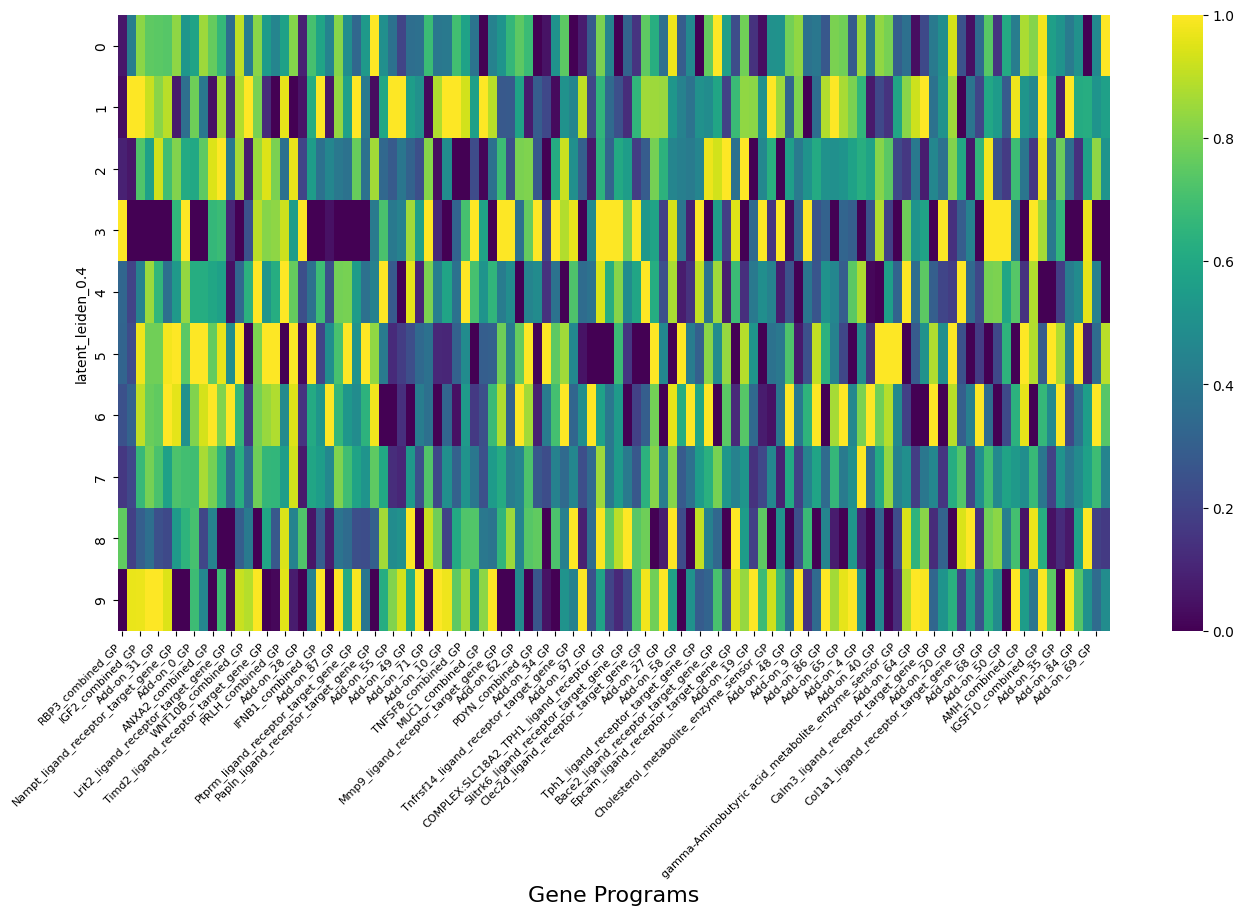

In [62]:
# Visualize GP activities of enriched GPs across niches
df = model.adata.obs[[latent_cluster_key] + enriched_gps].groupby(latent_cluster_key).mean()

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
normalized_df.index = df.index

plt.figure(figsize=(16, 8))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='viridis',
            annot=False,
            linewidths=0)
plt.xticks(rotation=45,
           fontsize=8,
           ha="right"
          )
plt.xlabel("Gene Programs", fontsize=16)
plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap.svg",
            bbox_inches="tight")

In [63]:
# Store gene program summary of enriched gene programs
save_file = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "niche_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]

enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

Now we will have a look at the GP activities and the log normalized counts of
the most important omics features of the differential GPs.

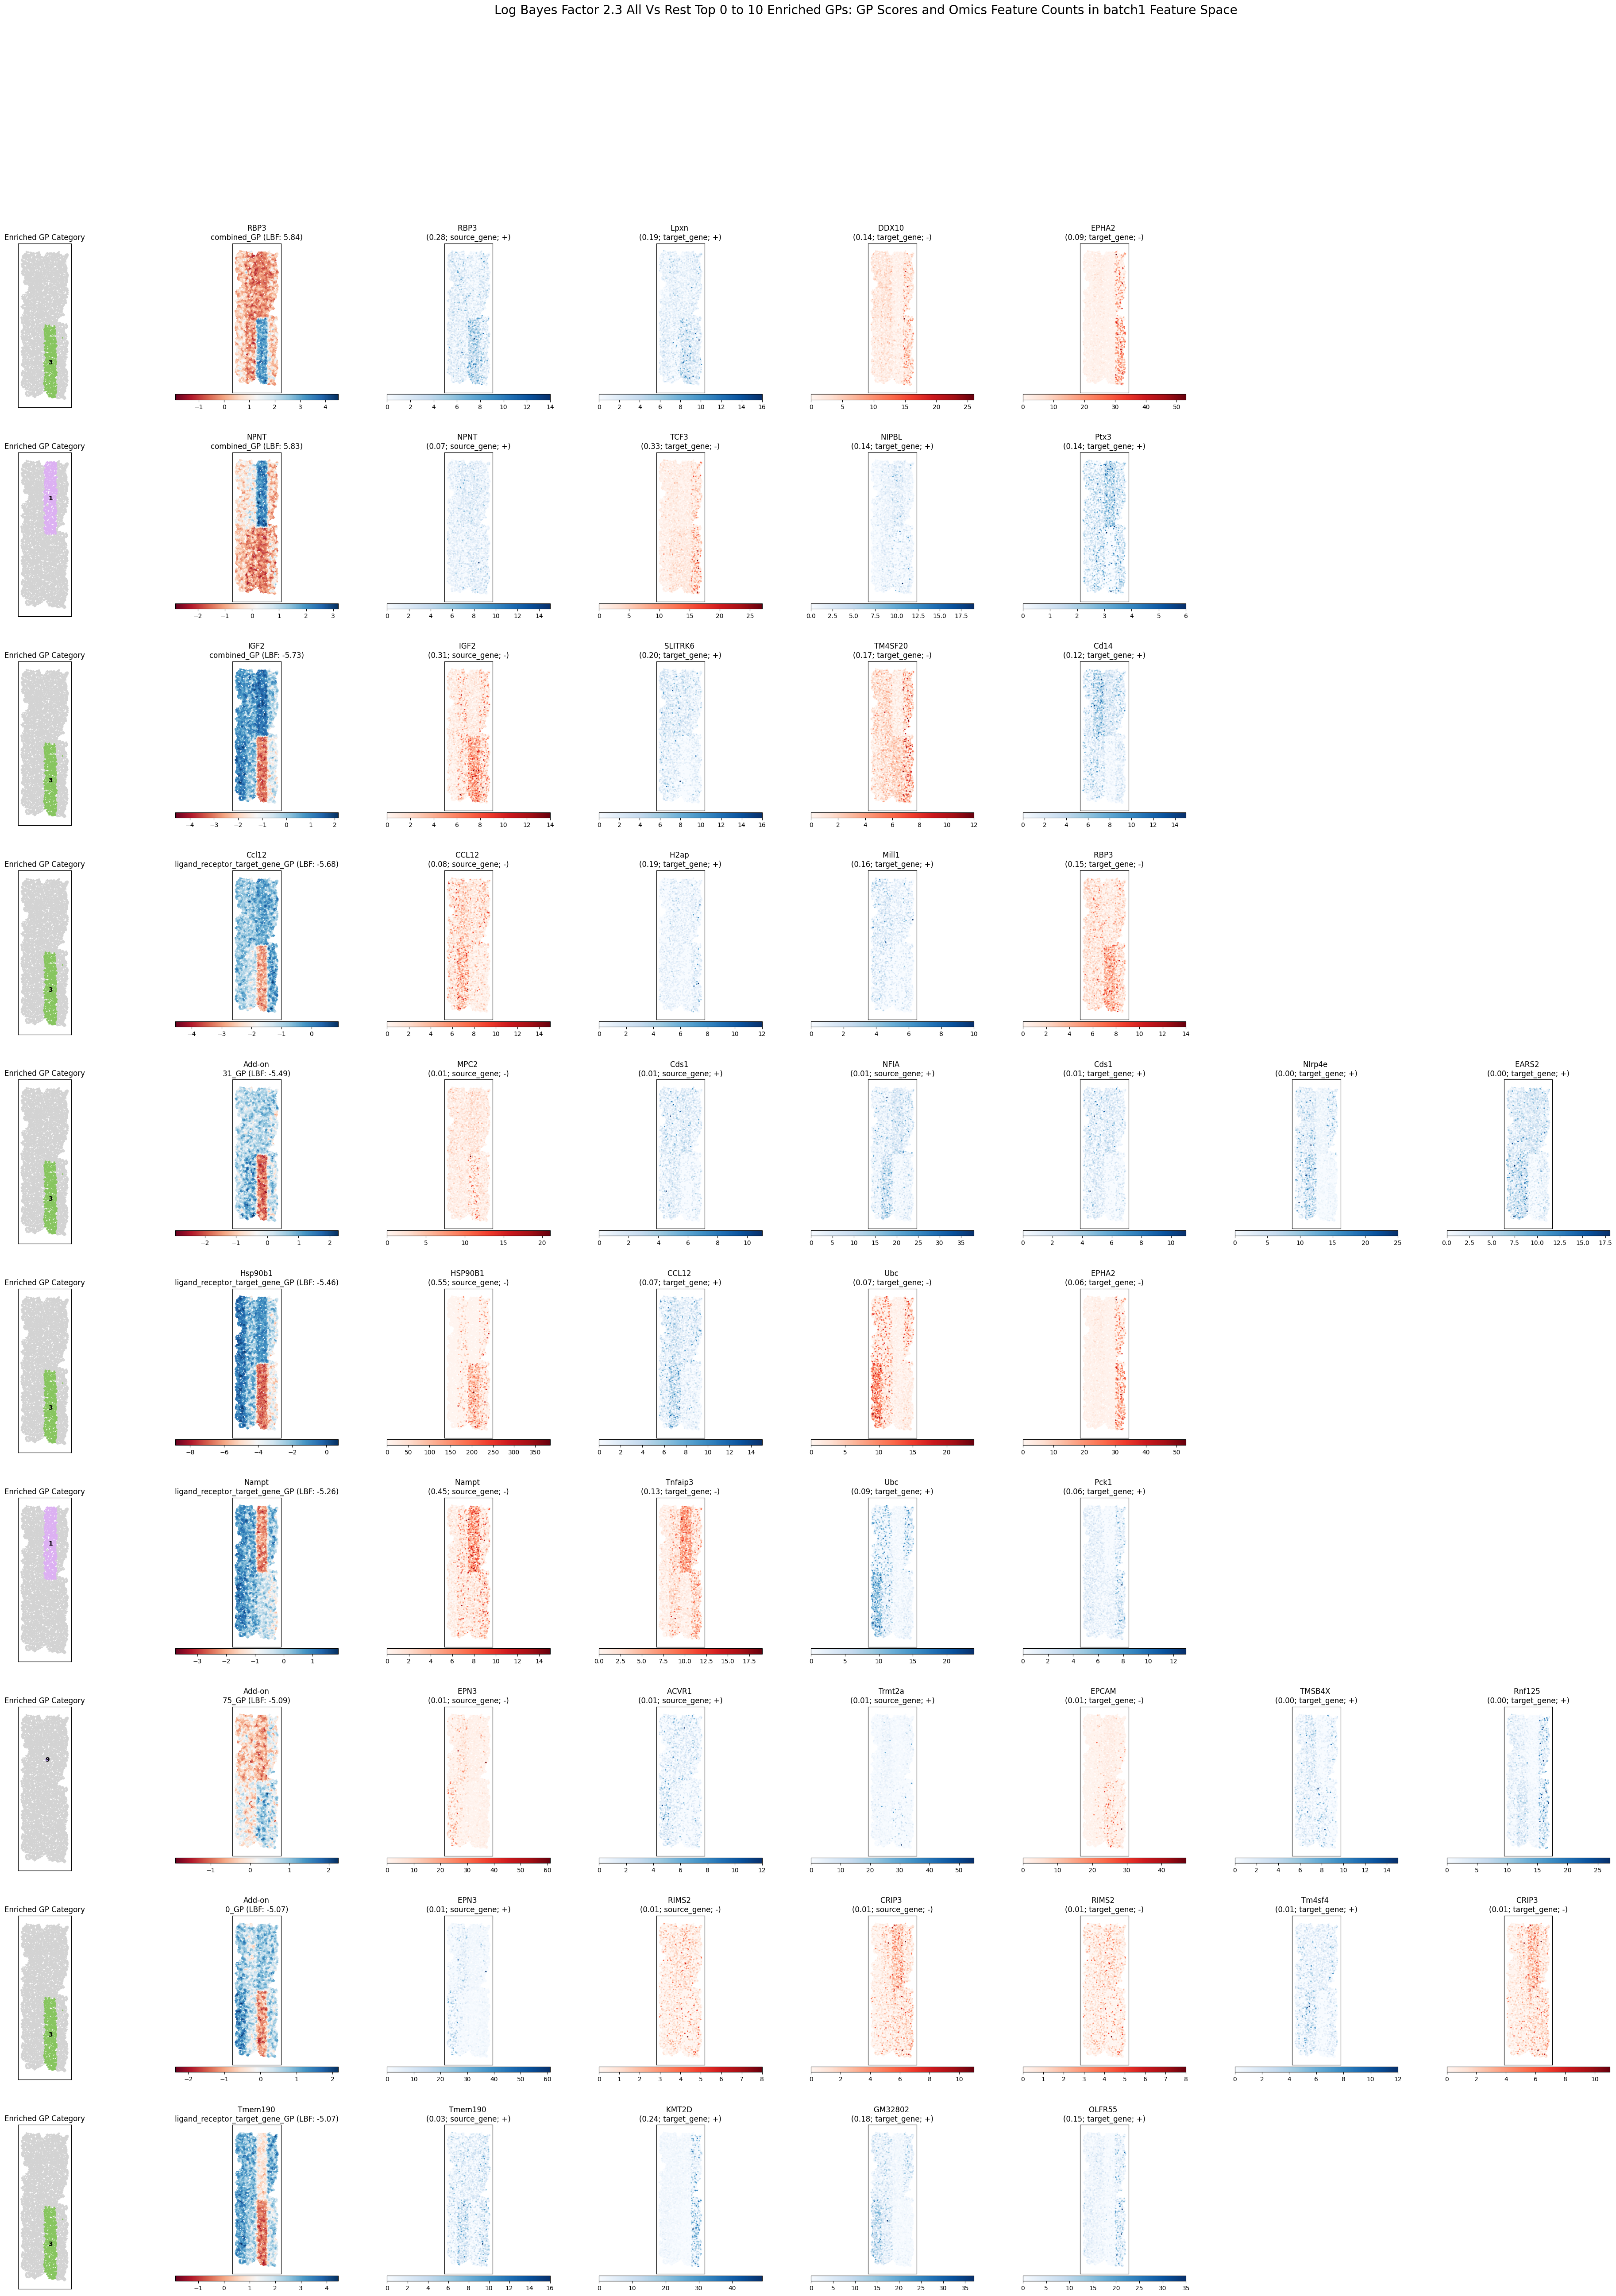

In [65]:
plot_label = f"log_bayes_factor_{log_bayes_factor_thresh}_all_vs_rest"
save_figs = True

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=latent_cluster_key,
    cat_palette=latent_cluster_colors,
    n_top_enriched_gp_start_idx=0,
    n_top_enriched_gp_end_idx=10,
    feature_spaces=samples, # ["latent"]
    n_top_genes_per_gp=3,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)

#### 4.3.3 Cell-cell Communication

Now we will use the inferred activity of an enriched combined interaction GP to analyze the involved intercellular interactions.

In [ ]:
gp_name = "Kl_ligand_receptor_target_gene_GP"

In [ ]:
network_df = compute_communication_gp_network(
    gp_list=[gp_name],
    model=model,
    group_key=latent_cluster_key,
    n_neighbors=n_neighbors)

visualize_communication_gp_network(
    adata=model.adata,
    network_df=network_df,
    figsize=(3, 7),
    cat_colors=latent_cluster_colors,
    edge_type_colors=["#1f77b4"], 
    cat_key=latent_cluster_key,
    save=True,
    save_path=f"{figure_folder_path}/gp_network_{gp_name}.svg",
    )